# Inverted pendulum
Reference: Steven L. Brunton, J. Nathan Kutz, Data Driven Science & Engineering: Machine Learning, Dynamical Systems, and Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1. Nonlinear system without control

In [2]:
# time iteration
def pendulum(time, dt, m, l, g, a, x):
    angle = [x[0]]
    N = np.array([[0.],[0.]]) # dummy

    for t in time[1:]:
        N[0] = x[1]
        N[1] = (-a*x[1]+l*g*m*np.sin(x[0]))/(m*l**2) # u=0
        x = x + dt*N
        angle.append(x[0])
    return angle

In [3]:
m = 1 # mass of the pendulum
l = 0.3 # length of the pendulum
g = 9.8 # gravity
a = 0.25 # coefficient of rotational friction

In [4]:
# time
t_end = 10
dt = 0.01
time = np.linspace(0, t_end, int(t_end/dt)+1)

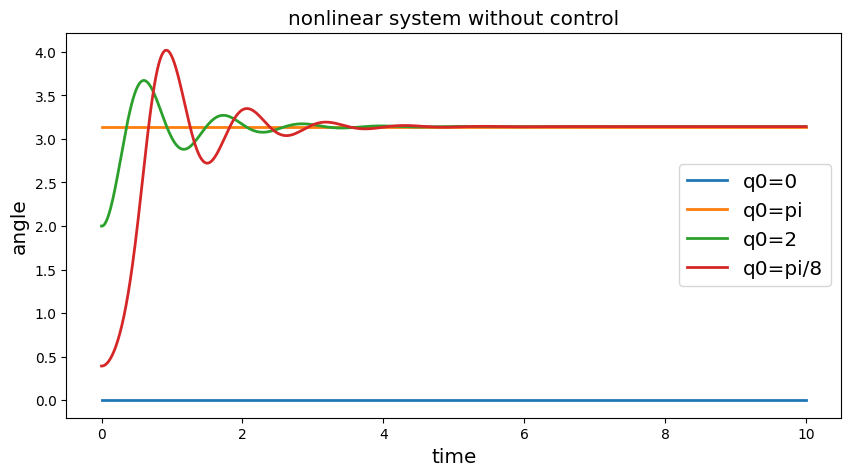

In [5]:
# state vectors
x0 = np.array([[0.],[0.]]) #initial q = 0. dq = 0
x1 = np.array([[np.pi],[0.]]) #initial q = pi dq = 0
x2 = np.array([[2.],[0.]]) #initial q = 1 dq = 0
x3 = np.array([[np.pi/8],[0.]]) #initial q = -1 dq = 0

# plot
plt.figure(figsize=(10,5))
plt.plot(time, pendulum(time, dt, m, l, g, a, x0), linewidth=2)
plt.plot(time, pendulum(time, dt, m, l, g, a, x1), linewidth=2)
plt.plot(time, pendulum(time, dt, m, l, g, a, x2), linewidth=2)
plt.plot(time, pendulum(time, dt, m, l, g, a, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('nonlinear system without control', fontsize="x-large")
plt.show()

## 2. Linearization

In [6]:
# x dot = Ax + Bu drived from the taylor expension of the equation at x=0
A = np.array([[0,1],[g/l,-a/(l**2*m)]])
B = np.array([[0],[1/(l*m)]])

### 2.1 Open loop linear system

In [7]:
# linearization
# open loop
def open_loop_pendulum(time, dt, A, x):
    angle = [x[0]]

    for t in time[1:]:
        x = x + dt*A @ x 
        angle.append(x[0])
    return angle

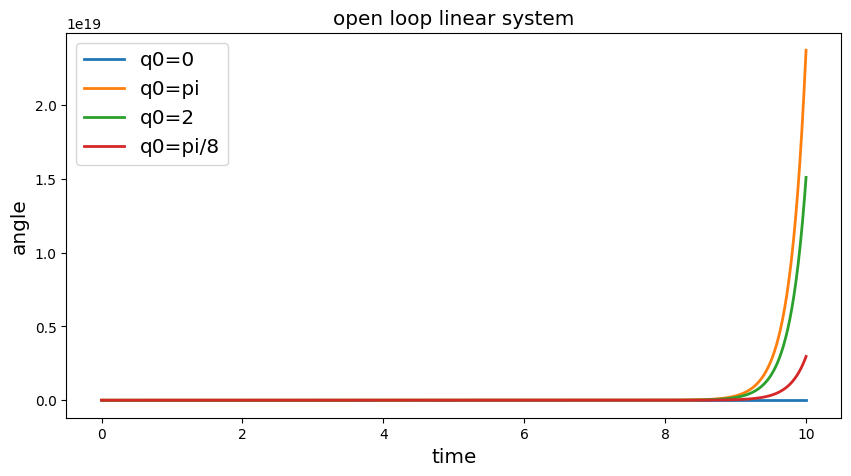

In [8]:
# plot
plt.figure(figsize=(10,5))
plt.plot(time, open_loop_pendulum(time, dt, A, x0), linewidth=2)
plt.plot(time, open_loop_pendulum(time, dt, A, x1), linewidth=2)
plt.plot(time, open_loop_pendulum(time, dt, A, x2), linewidth=2)
plt.plot(time, open_loop_pendulum(time, dt, A, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('open loop linear system', fontsize="x-large")
plt.show()

### 2.2 Controllability

In [9]:
# rank(C) = n iff controllability
controllability_matrix = np.hstack([B, A@B]) # [B AB A^2B .... A^(n-1)B]
print("Rank of the controllability matrix: ", np.linalg.matrix_rank(controllability_matrix)) 

Rank of the controllability matrix:  2


### 2.3 Observability

In [10]:
# rank(O) = n iff observability
C = np.array([[1,0]])
observability_matrix = np.vstack([C, C@A]) # [C CA^2 ... CA^(n-1)].T
print("Rank of the observability matrix: ", np.linalg.matrix_rank(observability_matrix)) 

Rank of the observability matrix:  2


### 2.4 Closed loop linear system with unstability

In [11]:
# linearization
# closed loop
def closed_loop_pendulum(time, dt, A, B, K, x):
    P = A - B @ K
    angle = [x[0]]

    for t in time[1:]:
        x = x + dt*(P @ x)
        angle.append(x[0])
    return angle

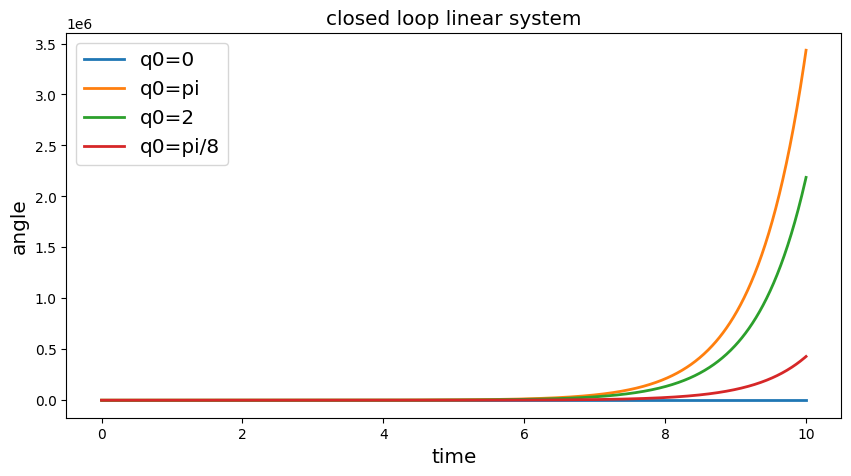

In [12]:
# 1. control gain u=-Kx (unstable)
K = np.array([[1, 5]]) # 1x2

plt.figure(figsize=(10,5))
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x0), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x1), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x2), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('closed loop linear system', fontsize="x-large")
plt.show()

### 2.5 Closed loop linear system with a suitable control gain K

In [13]:
# 1. control gain u=-Kx (stable) - LQR
Q = np.eye(2)
R = 1
P = scipy.linalg.solve_continuous_are(A, B, Q, R) # a solution of the Riccati equation
K = B.T @ P
print(K)

[[19.65088828  2.8388564 ]]


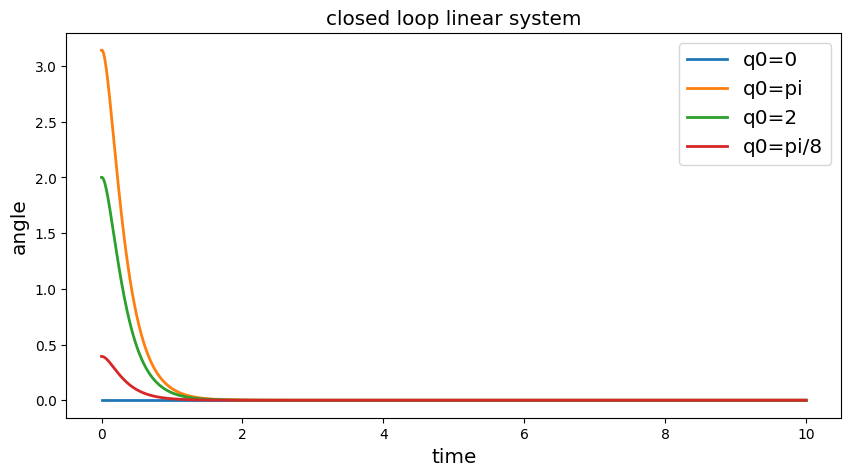

In [14]:
plt.figure(figsize=(10,5))
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x0), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x1), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x2), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('closed loop linear system', fontsize="x-large")
plt.show()

### 2.4 Closed loop linear system with a reference position

In [15]:
def closed_loop_pendulum_ref(time, dt, A, B, K, x, w_r):
    BK = B @ K
    P = A - BK
    angle = [x[0]]

    for t in time[1:]:
        x = x + dt*(P @ x + .5*BK @ w_r)
        angle.append(x[0])
    return angle

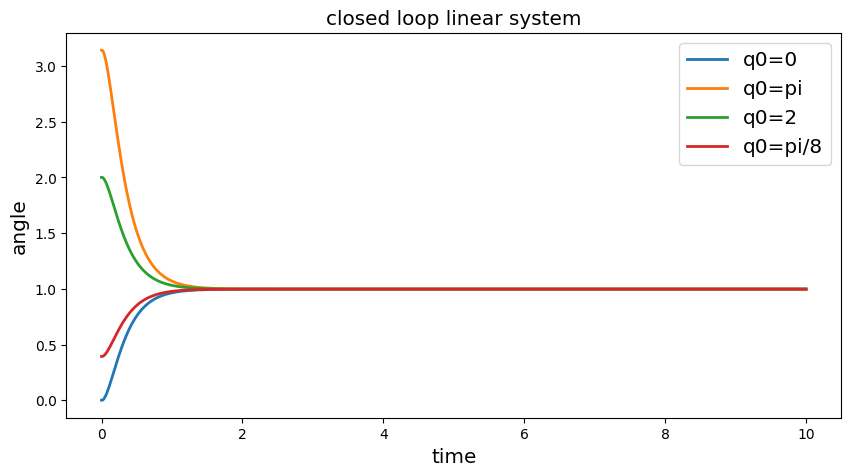

In [16]:
w_r = np.array([[1],[0.]])

plt.figure(figsize=(10,5))
plt.plot(time, closed_loop_pendulum_ref(time, dt, A, B, K, x0, w_r), linewidth=2)
plt.plot(time, closed_loop_pendulum_ref(time, dt, A, B, K, x1, w_r), linewidth=2)
plt.plot(time, closed_loop_pendulum_ref(time, dt, A, B, K, x2, w_r), linewidth=2)
plt.plot(time, closed_loop_pendulum_ref(time, dt, A, B, K, x3, w_r), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('closed loop linear system', fontsize="x-large")
plt.show()